# Downloads & Import

In [1]:
from sklearn.metrics import f1_score
import numpy as np
import scipy.sparse as sp
import pandas as pd
# import networkx as nx
from typing import List , Dict,Tuple
import torch
import json

import torch_geometric.nn as  gnn

import matplotlib.pyplot as plt
import torch
import time
import numpy as np
import random
from tqdm.notebook import tqdm

generator = torch.manual_seed(232)
np.random.seed(232)
torch.cuda.manual_seed(232)
torch.cuda.manual_seed_all(232)
random.seed(232)

%run "../src/train_test_confidence.py"


In [2]:
from torch_geometric.data import HeteroData
%run "../src/gnn.py"

class NeuroStockMultiClass(NeuroStock):

    def __init__(self, num_timeseries_features=1, n_companies=310, company_emb_size=32, node_emb_size=64, article_emb_size=768, n_industries=14, n_gnn_layers=3, type='sage', use_timeseries_only: bool = False, lstm: bool = True, graph_metadata: Tuple = None):
        super().__init__(num_timeseries_features, n_companies, company_emb_size, node_emb_size, article_emb_size, n_industries, n_gnn_layers, type, use_timeseries_only, lstm, graph_metadata)
        self.classifier = nn.Sequential(nn.Dropout(0.2),nn.Linear(node_emb_size, 2)).to(torch.float)
    
    def forward(self, hetero_x: HeteroData, return_representations=False):
        if self.lstm:
            companies_timeseries = self.lstm(hetero_x["company_timeseries"][:,:, -2:-1].to(torch.float))
        else:
            companies_timeseries = self.transformer(hetero_x["company_timeseries"][:,:,0:self.num_timeseries_features].to(torch.float))

        if self.use_timeseries_only:
            out = self.classifier(companies_timeseries)
            return out
        
        hetero_x["article"].x = self.project_article(hetero_x["article"].x)
        companies = self.company_embedding(hetero_x["company"].x)
        
        for k in hetero_x.edge_index_dict.keys():
            hetero_x[k].edge_index = hetero_x[k].edge_index.to(torch.int64)
        
        # print(hetero_x["company_timeseries"][:,:, -2:-1].to(torch.double).shape, hetero_x["company_timeseries"][:,:, -2:-1].to(torch.float).dtype)
        # company_timeseries is of shape (n_companies*batch_size, n_days, n_features)  the features are "open", "high", "low", "close", "volume"
        
        hetero_x["company"].x = torch.cat((companies_timeseries, companies), dim=-1)  #companies are in shape (n_companies*batch_size, node_emb_size)
        # hetero_x["company"].x = companies_timeseries + companies
        hetero_x["industry"].x = self.industry_embedding(hetero_x["industry"].x)
        graph = self.g_conv(hetero_x.x_dict, hetero_x.edge_index_dict)
        out = self.classifier(graph["company"])
        if return_representations:
            return out, graph["company"]
        return out
    
    def compute_loss(self, out, target):
        return F.cross_entropy(out, target)

In [3]:
"""
checkpoint model
"""
with open("../config_files/sage_sigma_titles_lstm_close_normal_target.json", 'r') as file:
    config = json.load(file)


model = torch.load(config["gnn_model"]["best_model_save_path"])
all_points = []
dataset = DayGraphs(config['graphs']['graph_path'])
for k in range(len(dataset)):
    all_points.append(dataset[k])

train_loader = GraphDataLoader(
        all_points[config['gnn_model']["start_day"]:config['gnn_model']["start_day"]+config['gnn_model']["train_size"]],
        batch_size=1, shuffle=False)
test_loader = GraphDataLoader(
    all_points[config['gnn_model']["start_day"]+config['gnn_model']["train_size"]:config['gnn_model']["start_day"]+config['gnn_model']["train_size"]+config['gnn_model']["test_interval"]],
    batch_size=1, shuffle=False)

def get_output(neurostock, data_loader, target_name="target"):

  neurostock.eval()
  device = next(neurostock.parameters()).device
  valid_losses = []
  # continue
  valid_outs = []
  valid_targets = []
  with torch.no_grad():
      for i, batch  in enumerate(data_loader):
        # if i > 2: break
        batch = batch.to(device)
        out = neurostock(batch)
        # print(out.squeeze(-1).unsqueeze(0))
        # print(batch["target"].shape)
        # break
        valid_outs.append(out.unsqueeze(0).cpu().detach())
        valid_targets.append(batch[target_name].unsqueeze(0).cpu().detach())
        loss = neurostock.compute_loss(out, batch[target_name])
        valid_losses.append(loss.item())
  valid_outs = torch.cat(valid_outs).numpy()
  valid_targets = torch.cat(valid_targets).numpy()
  return valid_outs, valid_targets

valid_outs, targets = get_output(model, test_loader, "target")

#### getting avg accuracy per company

<Axes: >

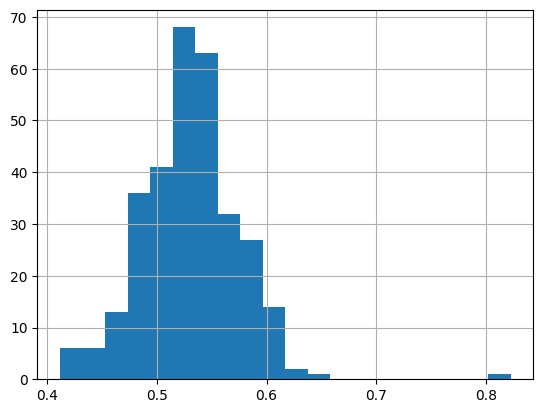

In [23]:
avg_acc_per_company = np.mean(valid_outs.argmax(-1)==targets, axis=0)
pd.Series(avg_acc_per_company).hist(bins=20)

#### analyzing accuracy for most mentioned companies

In [24]:

mentioned_companies = []
for batch in train_loader:
    mentioned_companies.append(batch["article", "main_company", "company"].edge_index[1])
most_mentioned = pd.Series(torch.cat(mentioned_companies)).value_counts()


In [34]:
print("mean high acc companies mentions",np.mean([ most_mentioned[k] for k in avg_acc_per_company.argsort()[-50:] if k in most_mentioned.index]))
print("median high acc companies mentions",np.median([ most_mentioned[k] for k in avg_acc_per_company.argsort()[-50:] if k in most_mentioned.index]))

mean high acc companies mentions 3846.469387755102
median high acc companies mentions 807.0


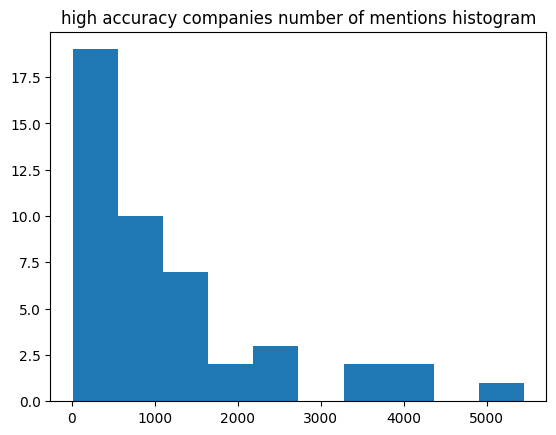

In [39]:
plt.title("high accuracy companies number of mentions histogram")
plt.hist([ most_mentioned[k] for k in avg_acc_per_company.argsort()[-50:] if k in most_mentioned.index and most_mentioned[k] < 10000])
plt.show()

In [36]:
print("mean low acc companies mentions", np.mean([ most_mentioned[k] for k in avg_acc_per_company.argsort()[:50] if k in most_mentioned.index]))
print("median low acc companies mentions", np.median([ most_mentioned[k] for k in avg_acc_per_company.argsort()[:50] if k in most_mentioned.index]))

mean low acc companies mentions 759.8125
median low acc companies mentions 302.5


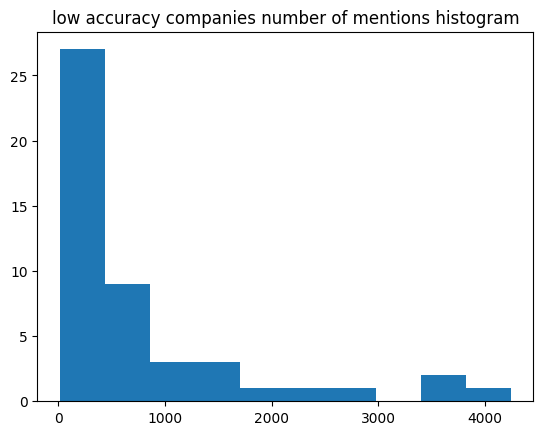

In [38]:
plt.title("low accuracy companies number of mentions histogram")
plt.hist([ most_mentioned[k] for k in avg_acc_per_company.argsort()[:50] if k in most_mentioned.index and most_mentioned[k] < 10000])
plt.show()

#### f1 score

In [47]:
f1_score(targets.reshape(-1),  valid_outs.argmax(-1).reshape(-1))


0.6406982473428592

#### companies with the highes accuracies

In [41]:
news_df = pd.read_csv("../../data/trained_files/processed_news_df.csv")
company_to_index = {k :v for v,k in zip(range(news_df["symbol"].nunique()), news_df["symbol"].unique()) }
index_to_company = {v:k for k,v in company_to_index.items()} #reverse


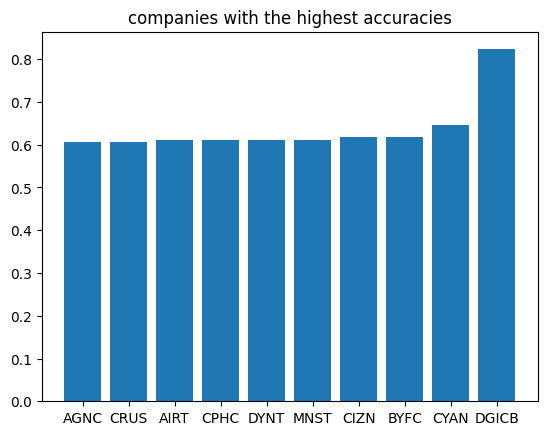

In [46]:
plt.title("companies with the highest accuracies")
plt.bar([index_to_company[company_index] for company_index in avg_acc_per_company.argsort()[-10:]],avg_acc_per_company[avg_acc_per_company.argsort()[-10:]])
plt.show()

#### accuracy over days after training 

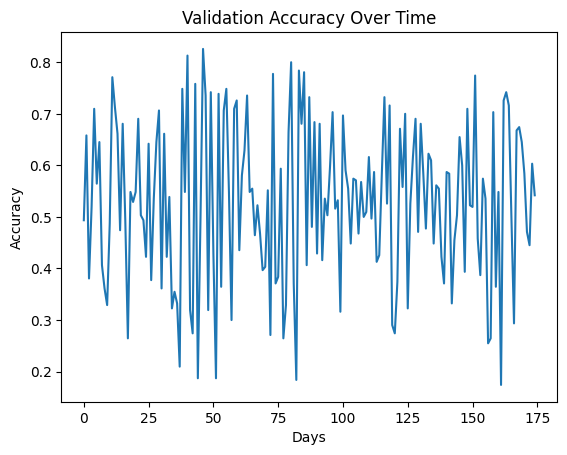

In [13]:
plt.plot(np.arange(valid_outs.shape[0]),np.mean(valid_outs.argmax(-1)==targets, axis=1))
plt.xlabel('Days')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Time')
plt.show()
#The model does not necessarily behave poorly when the test dataset goes 
# further away from the training data in the temporal dimension, which implies 
# that our model truly perceives and detects patterns instead of memorizing the data. 
 


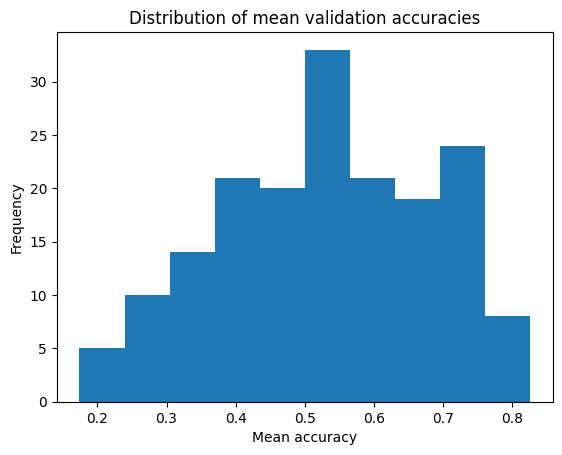

In [10]:
mean_acc = np.mean(valid_outs.argmax(-1)==targets, axis=1)

plt.hist(mean_acc, bins=10)

# Add axis labels and title
plt.xlabel('Mean accuracy')
plt.ylabel('Frequency')
plt.title('Distribution of mean validation accuracies')
plt.show()

#### plotting company representations

In [8]:

def get_output_representations(neurostock:NeuroStockMultiClass,  data_loader:GraphDataLoader):

  neurostock.eval()
  device = next(neurostock.parameters()).device
  # continue
  representations = []
  targets = []
  with torch.no_grad():
      for i, batch  in enumerate(data_loader):
        # if i > 2: break
        batch = batch.to(device)
        out = neurostock.forward(batch, return_representations=True)[1]
        representations.append(out.cpu().detach().unsqueeze(0))
        targets.append(batch["target"].cpu().detach().unsqueeze(0))

  representations = torch.cat(representations)
  targets = torch.cat(targets)
  return representations, targets

In [9]:
representations, targets = get_output_representations(model, test_loader)

In [57]:
avg_representatinos = representations[-10:].mean(axis=0).numpy()
avg_increment = targets[-10:].float().mean(axis=0).numpy()

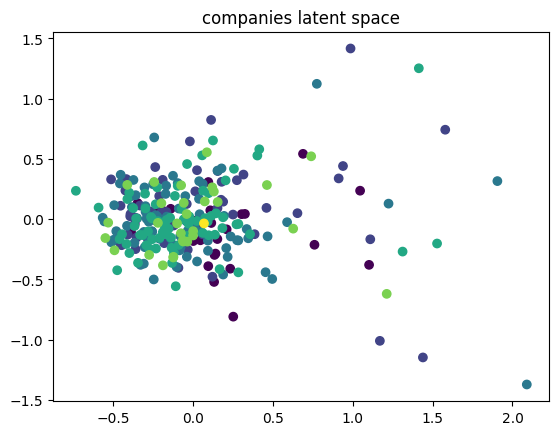

In [59]:
from sklearn.decomposition import PCA

reduced_representations = PCA(2).fit_transform(avg_representatinos[avg_increment.argsort()[20:-20]])
plt.title("companies latent space")
plt.scatter(reduced_representations[:,0], reduced_representations[:,1], c=avg_increment[avg_increment.argsort()[20:-20]])
plt.show() 